## 超参数

> 在机器学习的上下文中，超参数是在开始学习过程之前设置值的参数，而不是通过训练得到的参数数据。通常情况下，需要对超参数进行优化，给学习机选择一组最优超参数，以提高学习的性能和效果

[方差，标准差，平均值](https://www.cnblogs.com/quietwalk/p/8243536.html)

1. 超参数：在算法运行前需要决定的参数
2. 模型参数：算法过程中学习的参数

3. knn没有算法模型参数
4. knn算法中的k是典型的超参数

***一般我们常说的机器学习的调参指的就是超参数***

### 寻找最好的k

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [12]:
digits = datasets.load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [13]:
best_score = 0.0
best_k = 1

In [4]:
from sklearn.metrics import accuracy_score

In [15]:
for k in range(1, 11):
    knn_clf = KNeighborsClassifier(k)
    knn_clf.fit(X_train, y_train)
    score = knn_clf.score(X_test, y_test)
    if score > best_score:
        best_k = k
        best_score = score
best_k

5

In [16]:
best_score

0.9861111111111112

这就是机器学习中的调参数，如果best_k的值接近于11，那我们就应该继续拓展调参范围，如best_k为8，则继续调试8到20这个范围的值

在k近邻算法中还有一个重要的超参数就是距离的权重，比如：如果k为3，其中刚好有两个良性（蓝色）和一个恶心肿瘤（红色），如果只考虑k的话，则该是良性的，但是恶心的距离是最短的，所以预测点是恶心的可能性也很大

这样就需要一个权重计算，计算规则为距离的倒数比较。如，红色球距离预测点为1，一个篮球距离为3，另一个篮球距离是4，则篮球的距离为1/3+1/4=7/12，小于红色，所以红色获胜

还有一种情况，还可能存在平票的问题，也同样可以使用距离权重来计算

在KNeighborsClassifier的初始化里，是可以指定参数"weights"去考虑权重（默认是不使用的）,

In [21]:
KNeighborsClassifier?

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
    **kwargs,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : str or callable, optional (default = 'uniform')
    weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the sam

要不要去考虑距离呢？

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

best_score = 0.0
best_k = -1
best_method = ""
for method in ['uniform', 'distance']:
    for k in range(1, 11):
        knn_clf = KNeighborsClassifier(k)
        knn_clf.fit(X_train, y_train)
        score = knn_clf.score(X_test, y_test)
        if score > best_score:
            best_k = k
            best_score = score
            best_method = method
best_k

5

In [26]:
best_method

'uniform'

从上面测试可知，对于上面的这个问题是不需要考虑距离的

在这之前讲的距离都是欧拉距离，在实际应用中，不止，还有曼哈顿距离等，具体需要用哪个也是需要调试的，所以距离p也是一个超参数

在KNeighborsClassifier初始化的，有一个[metric](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric)参数就是指定"明科夫斯基距离"(默认)，并且可以用p参数去指定具体的值使用哪种公式（1为manhattan，默认2为euclidean），前提是要开启上面讲的weights参数

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [61]:
%%time

best_score = 0.0
best_k = -1
best_p = -1
for k in range(1, 11):
    for p in range(1, 6):
        knn_clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=p, metric='minkowski')
        knn_clf.fit(X_train, y_train)
        score = knn_clf.score(X_test, y_test)
        if score > best_score:
            best_k = k
            best_score = score
            best_p = p
            
print('best_p:{}'.format(best_p))
print('best_k:{}'.format(best_k))
print('best_score:{}'.format(best_score))

best_p:4
best_k:1
best_score:0.9888888888888889
CPU times: user 36.6 s, sys: 50 ms, total: 36.6 s
Wall time: 36.6 s


## Grid Search 网格搜索

Grid Search：一种调参手段；穷举搜索：在所有候选的参数选择中，通过循环遍历，尝试每一种可能性，表现最好的参数就是最终的结果。其原理就像是在数组里找最大值。（为什么叫网格搜索？以有两个参数的模型为例，参数a有3种可能，参数b有4种可能，把所有可能性列出来，可以表示成一个3*4的表格，其中每个cell就是一个网格，循环过程就像是在每个网格里遍历、搜索，所以叫grid search）

In [47]:
param_grid = [
    {
        'weights': ['uniform'], # 不开启距离权重
        'n_neighbors': [k for k in range(1, 11)],
    },
    {
        'weights': ['distance'],# 开启距离权重
        'n_neighbors': [k for k in range(1, 11)],
        'p': [p for p in range(1, 6)] # 使用的距离公式
    }
]

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
# 创建一个默认的实例
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid)

In [50]:
%%time
grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 1min 40s, sys: 70 ms, total: 1min 40s
Wall time: 1min 40s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform']},
                         {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'p': [1, 2, 3, 4, 5], 'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

在运行网搜索完后，使用best_estimator_ 查看最佳的参数组合

In [55]:
# 拿到分类器
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=3,
                     weights='distance')

In [53]:
grid_search.best_score_

0.9895615866388309

跟上面的结果不太一样，是因为机器学习算法好坏评判标准不一样

In [54]:
grid_search.best_params_

{'n_neighbors': 1, 'p': 3, 'weights': 'distance'}

In [60]:
# 拿到最佳的分类器
knn_clf = grid_search.best_estimator_
knn_clf.predict(X_test)

array([1, 3, 7, 3, 2, 4, 6, 1, 4, 0, 4, 7, 8, 9, 2, 8, 3, 6, 7, 0, 6, 0,
       8, 3, 0, 6, 2, 3, 0, 9, 0, 2, 0, 6, 9, 1, 1, 5, 8, 0, 6, 1, 5, 8,
       9, 5, 1, 6, 2, 6, 6, 7, 6, 7, 7, 2, 7, 8, 0, 7, 3, 6, 3, 9, 6, 6,
       5, 5, 4, 2, 1, 3, 7, 6, 5, 7, 2, 8, 1, 2, 2, 8, 1, 1, 6, 3, 5, 0,
       0, 1, 6, 7, 6, 8, 9, 7, 0, 0, 9, 8, 0, 8, 2, 3, 6, 1, 9, 9, 1, 7,
       8, 9, 8, 8, 5, 9, 5, 1, 1, 9, 9, 3, 3, 2, 8, 1, 3, 8, 6, 4, 0, 0,
       0, 7, 1, 5, 5, 1, 8, 5, 1, 8, 8, 6, 9, 9, 4, 5, 7, 5, 2, 1, 2, 3,
       8, 7, 7, 5, 1, 9, 1, 9, 8, 0, 6, 1, 2, 1, 3, 3, 8, 9, 6, 8, 4, 1,
       0, 0, 9, 8, 7, 2, 8, 6, 4, 8, 9, 4, 2, 6, 1, 8, 5, 6, 7, 5, 1, 9,
       2, 8, 3, 2, 9, 4, 8, 5, 5, 6, 2, 4, 3, 2, 6, 4, 8, 5, 8, 0, 8, 8,
       6, 3, 2, 3, 0, 5, 7, 1, 3, 9, 3, 2, 1, 6, 6, 5, 1, 9, 7, 2, 4, 5,
       2, 1, 3, 1, 1, 2, 1, 7, 0, 1, 2, 2, 1, 2, 4, 8, 6, 6, 3, 9, 2, 8,
       1, 5, 5, 1, 8, 6, 2, 5, 6, 0, 1, 4, 2, 1, 8, 9, 4, 3, 0, 6, 8, 3,
       3, 2, 0, 2, 5, 6, 5, 6, 6, 4, 6, 1, 8, 3, 4,

In [59]:
knn_clf.score(X_test, y_test)

0.9833333333333333

GridSearchCV的原理就是利用传进去的param_grid创建多个分类器，然后分别跑出不通的结果作比较，这里也可以通过初始化GridSearchCV时做一些优化

- n_jobs：启用机器的多核优势，提供并行运行，-1指自动根据机器来启动，也可以自己指定几核
- verbose：指定在运行中，给出一些输出内容，给出一个整数，值越大，输出的内容越详细

GridSearchCV(knn, param_grid, n_jobs=-1, verbose=2)

## 数据归一化

![](http://src.blog.oldsyang.com/images/machine-l/20191221220645.jpg)

样本一和样本二间的距离为：sqrt((200-100)**2 + (1-5)**2)，可以发现样本间的距离完全受发现时间所主导 

![](http://src.blog.oldsyang.com/images/machine-l/20191221222038.jpg)

从上图又看出可以发现样本间的距离主要受肿瘤大小的影响

所以要将所有数据映射到统一尺度上

最常见的是***最值归一化 normalization***

![](http://src.blog.oldsyang.com/images/machine-l/20191221222938.jpg)

In [65]:
def Normalization(x):
    return [(float(i)-min(x))/float(max(x)-min(x)) for i in x]

最值归一化适用于分布有明显边界的情况；受outlier影响大。比如一个人的收入是100万，而大多数人工资为1万。则收入为100万的归值为1，而其他的人都在0.01这个值。这种情况下，则需要另外一种归一化：***均值方差归一化 standardization***

![](http://src.blog.oldsyang.com/images/machine-l/20191221224610.jpg)

### 最值归一化 normalization

In [112]:
import numpy as np
import matplotlib.pyplot as plt

In [143]:
np.random.seed(666)
x = np.random.randint(0, 100, size=100)
x

array([ 2, 45, 30, 62, 70, 73, 30, 36, 61, 91, 94, 51, 60, 95, 28, 14, 97,
       63, 16, 46, 39, 69, 82, 76, 79, 13, 69, 20, 11, 24, 20, 36, 48, 36,
       94, 46, 47, 16, 77, 36, 26,  5, 42, 45, 33, 64, 94, 64, 27, 14, 38,
       64, 92, 83,  2, 91, 34, 86, 27, 79, 38, 27, 80, 57, 83, 38,  9, 51,
       77, 45,  2, 88, 63, 23, 11, 71, 54, 84, 47, 19, 40, 47, 21, 93, 99,
       83,  5, 25, 89, 69,  4, 12, 60, 58, 18, 69, 20, 52, 25, 63])

In [144]:
(x - np.min(x)) / (np.max(x) - np.min(x))

array([0.        , 0.44329897, 0.28865979, 0.6185567 , 0.70103093,
       0.73195876, 0.28865979, 0.35051546, 0.60824742, 0.91752577,
       0.94845361, 0.50515464, 0.59793814, 0.95876289, 0.26804124,
       0.12371134, 0.97938144, 0.62886598, 0.1443299 , 0.45360825,
       0.3814433 , 0.69072165, 0.82474227, 0.7628866 , 0.79381443,
       0.11340206, 0.69072165, 0.18556701, 0.09278351, 0.22680412,
       0.18556701, 0.35051546, 0.4742268 , 0.35051546, 0.94845361,
       0.45360825, 0.46391753, 0.1443299 , 0.77319588, 0.35051546,
       0.24742268, 0.03092784, 0.41237113, 0.44329897, 0.31958763,
       0.63917526, 0.94845361, 0.63917526, 0.25773196, 0.12371134,
       0.37113402, 0.63917526, 0.92783505, 0.83505155, 0.        ,
       0.91752577, 0.32989691, 0.86597938, 0.25773196, 0.79381443,
       0.37113402, 0.25773196, 0.80412371, 0.56701031, 0.83505155,
       0.37113402, 0.07216495, 0.50515464, 0.77319588, 0.44329897,
       0.        , 0.88659794, 0.62886598, 0.21649485, 0.09278

In [145]:
# 对于矩阵的处理
X = np.random.randint(0, 100, (50, 2))
X[:10, :]

array([[91, 26],
       [16, 68],
       [78, 13],
       [17, 58],
       [74, 44],
       [90, 79],
       [42, 20],
       [33, 39],
       [37, 93],
       [12, 82]])

In [146]:
X = np.array(X, dtype=float)
X[:10, :]

array([[91., 26.],
       [16., 68.],
       [78., 13.],
       [17., 58.],
       [74., 44.],
       [90., 79.],
       [42., 20.],
       [33., 39.],
       [37., 93.],
       [12., 82.]])

In [154]:
# 对第一行进行归一化
# X[:, 0] = (X[:, 0] - np.min(X[:, 0])) / (np.max(X[:, 0]) - np.min(X[:, 0]))

In [147]:
# 循环设置
col_count = X.shape[1]
for col in range(col_count):
    X[:, col] = (X[:, col] - np.min(X[:, col])) / (np.max(X[:, col]) - np.min(X[:, col]))

In [148]:
X[:10, 0]

array([1.        , 0.15730337, 0.85393258, 0.16853933, 0.80898876,
       0.98876404, 0.4494382 , 0.34831461, 0.39325843, 0.11235955])

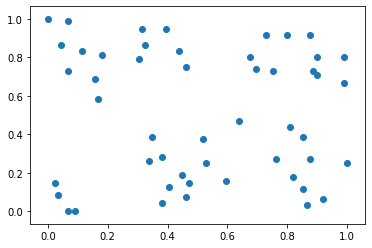

In [149]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [150]:
np.mean(X[:, 0])

0.5143820224719101

In [151]:
np.std(X[:, 0])

0.3139020196971553

In [152]:
np.mean(X[:, 1])

0.506875

In [153]:
np.std(X[:, 1])

0.330578525404076

### 均值方差归一化 standardization

In [11]:
import matplotlib.pyplot as plt
X2 = np.random.randint(0, 100, (50, 2))
X2 = np.array(X2, dtype=float)
X2[:10, 0]

array([60., 77., 22., 24., 88., 87., 91., 30.,  8., 95.])

In [12]:
# 循环设置
col_count = X2.shape[1]
for col in range(col_count):
    X2[:, col] = (X2[:, col] - np.mean(X2[:, col])) / np.std(X2[:, col])

In [13]:
X2[:10, 0]

array([ 0.41236383,  0.99654592, -0.89345496, -0.82472766,  1.3745461 ,
        1.34018245,  1.47763706, -0.61854574, -1.3745461 ,  1.61509167])

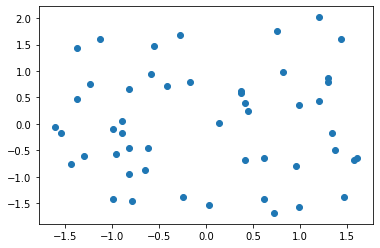

In [14]:
plt.scatter(X2[:, 0], X2[:, 1])
plt.show()

In [15]:
np.mean(X2[:, 0])

1.3322676295501878e-17

In [31]:
np.std(X2[:, 0])

1.0

In [50]:
np.std(X2[:, 0], ddof=1)

1.0101525445522108

In [51]:
import pandas as pd
cc = pd.DataFrame(X2[: ,0])
cc.std()

0    1.010153
dtype: float64

In [53]:
np.mean(X2[:, 1])

4.884981308350689e-17

In [54]:
np.std(X2[:, 1])

1.0

这样就形成了一个均值（中心值）为0，标准差（分布幅度）为1的数据，即使有大的偏离原始数据，也不会有偏值

在训练时候得到的均值和方差，应该适用于之后的测试数据集

![](http://src.blog.oldsyang.com/images/machine-l/20191222005809.jpg)

## sklearn中的Scaler

![](http://src.blog.oldsyang.com/images/machine-l/20191222010047.jpg)

In [182]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [205]:
iris = datasets.load_iris()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

### StandardScaler

In [206]:
# 均值方差归一化
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
standardscaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [207]:
# 均值
standardscaler.mean_

array([0.00000000e+00, 3.04105776e-01, 5.15309673e+00, 1.18364649e+01,
       1.18997912e+01, 5.79749478e+00, 1.38065414e+00, 1.25260960e-01,
       5.56715379e-03, 1.98469033e+00, 1.03061935e+01, 1.20389701e+01,
       1.03159360e+01, 8.16423104e+00, 1.87752262e+00, 1.14126653e-01,
       3.47947112e-03, 2.63256785e+00, 9.89074461e+00, 6.91788448e+00,
       7.06819763e+00, 7.80027836e+00, 1.82950592e+00, 5.21920668e-02,
       1.39178845e-03, 2.50034795e+00, 9.12386917e+00, 8.83368128e+00,
       9.90883786e+00, 7.67223382e+00, 2.42379958e+00, 2.08768267e-03,
       0.00000000e+00, 2.42797495e+00, 7.69380654e+00, 8.99721642e+00,
       1.02032011e+01, 8.85455811e+00, 2.98747390e+00, 0.00000000e+00,
       1.11343076e-02, 1.64439805e+00, 6.94502436e+00, 7.32011134e+00,
       7.64231037e+00, 8.23034099e+00, 3.48573417e+00, 2.08768267e-02,
       9.04662491e-03, 6.91022965e-01, 7.54627697e+00, 9.56158664e+00,
       9.52679193e+00, 8.67988866e+00, 3.66527488e+00, 1.89283229e-01,
      

In [208]:
# 标准差(描述数据的分布范围)
standardscaler.scale_

array([1.        , 0.91917854, 4.74340319, 4.21570194, 4.26354895,
       5.68618386, 3.31576255, 1.00778218, 0.0912126 , 3.18438946,
       5.47616299, 3.93066364, 4.75177622, 5.99705573, 3.64179366,
       0.84468259, 0.06970762, 3.59366138, 5.64058307, 5.8220127 ,
       6.15612897, 6.18592021, 3.31223969, 0.45468687, 0.03728071,
       3.13722901, 6.18514795, 5.87347752, 6.15826175, 5.85635415,
       3.7665807 , 0.04564345, 1.        , 3.55176409, 6.30180823,
       6.32004185, 5.98436058, 5.87237275, 3.55293742, 1.        ,
       0.16223442, 3.08240877, 6.53956732, 6.49676054, 6.29832176,
       5.68952921, 4.32942044, 0.25490825, 0.22827664, 1.71017956,
       5.64812386, 5.20570585, 5.33043274, 6.04522211, 4.89315182,
       0.92987041, 0.02637063, 0.96106948, 5.09582695, 4.33267656,
       4.97481255, 5.91709484, 4.03309182, 1.82425031])

In [209]:
# X_train 并没有发生变化，需要重新赋值一下
X_train = standardscaler.transform(X_train)

In [210]:
X_train

array([[ 0.        ,  0.75708275,  1.2326389 , ...,  1.07622545,
         3.47162733,  2.55240645],
       [ 0.        , -0.33084516,  0.38936249, ..., -1.12079866,
        -0.49555237, -0.18844549],
       [ 0.        , -0.33084516,  0.81100069, ...,  0.40021803,
        -0.49555237, -0.18844549],
       ...,
       [ 0.        , -0.33084516, -0.24309482, ..., -1.12079866,
        -0.49555237, -0.18844549],
       [ 0.        , -0.33084516,  1.443458  , ..., -1.12079866,
        -0.49555237, -0.18844549],
       [ 0.        ,  0.75708275,  0.38936249, ..., -1.12079866,
        -0.49555237, -0.18844549]])

In [215]:
# 测试数据集也必须归一化处理
X_test_standard = standardscaler.transform(X_test)

In [212]:
from sklearn.neighbors import KNeighborsClassifier

In [213]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [214]:
knn.score(X_test_standard, y_test)

0.975

### 实现StandardScaler

在lib增加一个preprocessing.py，代码如下:

In [2]:
import numpy as np

class StandardScaler:

    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        """根据训练数据集X获得数据的均值和方差"""
        assert X.ndim == 2, "The dimension of X must be 2"

        self.mean_ = np.array([np.mean(X[:,i]) for i in range(X.shape[1])])
        self.scale_ = np.array([np.std(X[:,i]) for i in range(X.shape[1])])

        return self

    def transform(self, X):
        """将X根据这个StandardScaler进行均值方差归一化处理"""
        assert X.ndim == 2, "The dimension of X must be 2"
        assert self.mean_ is not None and self.scale_ is not None, \
               "must fit before transform!"
        assert X.shape[1] == len(self.mean_), \
               "the feature number of X must be equal to mean_ and std_"

        resX = np.empty(shape=X.shape, dtype=float)
        for col in range(X.shape[1]):
            resX[:,col] = (X[:,col] - self.mean_[col]) / self.scale_[col]
        return resX

## K领近算法总结

![](http://src.blog.oldsyang.com/images/machine-l/20191222153835.jpg)

In [3]:
import numpy as np

In [46]:
C = np.array([1, 2, 3])
(1/C.size) * sum((C - C.mean())**2)

0.6666666666666666

In [49]:
C.var()

0.6666666666666666

In [4]:
np.std([1, 2, 3])

0.816496580927726

In [5]:
np.std([1, 2, 3], ddof=1)

1.0

In [55]:
import sklearn

In [56]:
sklearn.__version__

'0.21.3'

In [57]:
28*28

784